In [3]:
import sys
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
if 'google.colab' in sys.modules:
    os.system('apt install python3-mpi4py cython3 libxc-dev gpaw-data')
    os.system('pip install --upgrade gpaw pymatgen')

In [6]:
from ase.build import bulk
from ase.atom import Atom
from ase.atoms import Atoms
from gpaw import GPAW, PW
from ase.visualize.plot import plot_atoms
from ase.visualize import view
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.rc('figure', figsize=(18,6))
plt.rc('font', size=20)
from ase.eos import EquationOfState

In [7]:
#def econvergence(E: list[float]):
 #   return np.abs((E[:-1] - E[-1])/E[-1])

def load_calc(filename, **kwargs):
    if os.path.exists(filename):
        calc = GPAW(filename)
    else:
        calc = GPAW(**kwargs)
    return calc
        

## Genero Estructura

In [8]:
AuFCC = bulk('Au', 'fcc', a=4., cubic=True)

In [9]:
calc = GPAW(mode=PW(300), xc='PBE', txt='AuFCC.txt',kpts=[5,5,5])
AuFCC.set_calculator(calc)
AuFCC.get_potential_energy()

-11.567181560509455

In [10]:
import os

In [11]:
calcsdir='calcs_kpoints'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [12]:
structures = [('fcc', AuFCC, 4.0)]

In [13]:
kpoints = [3, 4, 5,7,9,11,13]
Ekpt = {}

In [14]:
for case in structures:
    name, struc, latpar = case
    Ekpt[name] = np.array([])
    for kpt in tqdm(kpoints):
        # Energía cinética de corte 300 eV. Divido celda en grilla de "kpt*kpt*kpt"
        # archivos GPAW y txt a guardar 
        gpawfile =os.path.join(calcsdir, f'{name}_kpts_{kpt}.gpaw')
        logfile = os.path.join(calcsdir, f'{name}_{kpt}.txt')
        # cargo el calculador con la función definida antes
        calc = load_calc(gpawfile, mode=PW(300), txt=logfile, xc='PBE', kpts=[kpt,kpt,kpt])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ekpt[name]=np.append(Ekpt[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(gpawfile)

  0%|          | 0/7 [00:00<?, ?it/s]

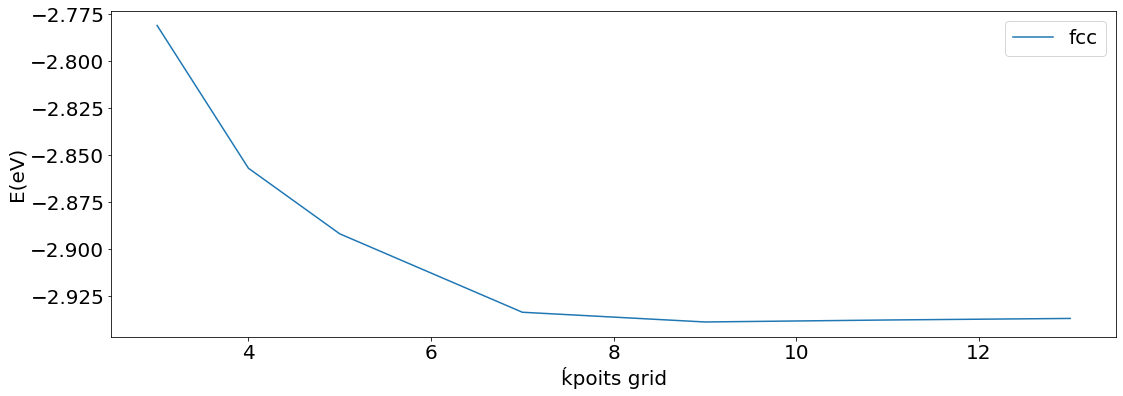

In [120]:
plots = [plt.plot(kpoints, energies, label = struc) for struc, energies in Ekpt.items()]
plt.ylabel('E(eV)')
plt.xlabel('ḱpoits grid')
plt.legend()
plt.savefig("E Vs kpoits.jpg")

In [16]:
KPT= 10

## Cuttoff Convergence

In [17]:
calcsdir = 'calcs_ecut'
if not os.path.exists(calcsdir):
    os.makedirs(calcsdir)

In [18]:
ecuts = [200, 250, 300, 400, 500,600]
Ecutoff = {}

In [19]:
structures

[('fcc',
  Atoms(symbols='Au4', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  4.0)]

In [20]:
for case in structures:
    name, struc, latpar = case
    Ecutoff[name] = np.array([])
    progress = tqdm(ecuts)
    for ecut in progress:
        filename = os.path.join(calcsdir, f'{name}_{ecut}.gpaw')
        logfilename = os.path.join(calcsdir, f'{name}_{ecut}.txt')
        # Energía cinética de corte "ecut" eV. Divido celda en grilla de "KPT*KPT*KPT".
        calc = load_calc(filename, mode=PW(ecut), txt=logfilename, xc='PBE', kpts=[KPT,KPT,KPT])
        struc.set_calculator(calc)
        # Divide la energía potencial por el número de átomos, para normalizar, por si llegara a comparar estructuras con diferente cantidad de átomos.
        Ecutoff[name]=np.append(Ecutoff[name], struc.get_potential_energy()/struc.get_global_number_of_atoms())
        struc.calc.write(filename)

  0%|          | 0/6 [00:00<?, ?it/s]

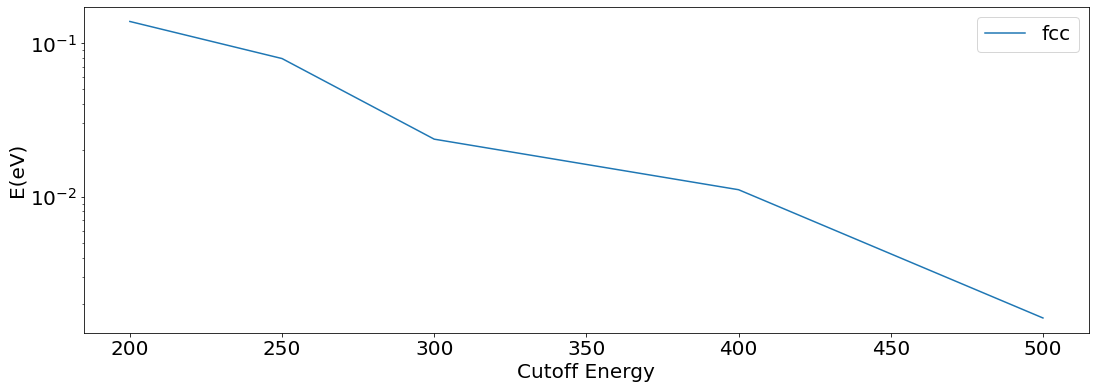

In [119]:
[plt.plot(ecuts[:-1], np.abs((energies[:-1]-energies[-1])/energies[-1]), label = name) for name, energies in Ecutoff.items()]
plt.yscale('log')
plt.ylabel('E(eV)')
plt.xlabel('Cutoff Energy')
plt.legend()
plt.savefig("E Vs. Cutoff energy.jpg")

In [22]:
ECUT = 400

## Lattice Parameter

In [23]:
latparams = {'fcc': np.linspace(3.8,4.5,10)}

In [24]:
def evcurve(element, structure, sizes, calculator):
    print(f'working on {element} in {structure}')
    structures = []
    E = []
    V = []
    progress = tqdm(sizes)
    for a in progress:
        calc = GPAW(mode=PW(ECUT), xc='PBE', txt=f'{element}{structure}_{a}.txt',kpts=[KPT,KPT,KPT])
        structures.append(bulk(element, structure, a=a, cubic=True))
        structures[-1].set_calculator(calculator)
        E.append(structures[-1].get_potential_energy())
        V.append(structures[-1].get_volume())
    return {'E': E, 'V': V, 'strucs': structures}

In [25]:
import ase, gpaw
def doevcurve(name: str, struc: ase.atoms.Atoms, sizes: np.ndarray, gpaw_kwargs:dict):
    """
    name: str con el nombre de la estructura
    struc: atoms object con la estructura a calcular
    sizes: np.ndarray con los parametros de red para esta estructura
    gpaw_kwargs: opciones para gpaw
    """
    E = []
    V = []
    progress = tqdm(sizes)
    for latpar in progress:
        gpawfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.gpaw')
        logfile = os.path.join(latparcalcs, f'{name}_latpar_{latpar:.2f}.txt')
        gpaw_kwargs.update({'txt': logfile})
        calc = load_calc(gpawfile, **gpaw_kwargs)
        struc.set_cell(latpar*np.eye(3), scale_atoms=True) # ojo, esto vale solo para cubicas !
        struc.set_calculator(calc)
        V.append(struc.get_volume())
        E.append(struc.get_potential_energy())
        struc.calc.write(gpawfile)
    return {'V': V, 'E': E}

In [26]:
GPAW_KWARGS = dict(mode=PW(ECUT), xc='PBE', kpts=[KPT,KPT,KPT])

In [27]:
latparcalcs = 'calcs_latpar'

if not os.path.exists(latparcalcs):
    os.makedirs(latparcalcs)

In [28]:
evcurves={}

In [29]:
structures

[('fcc',
  Atoms(symbols='Au4', pbc=True, cell=[4.0, 4.0, 4.0], calculator=GPAW(...)),
  4.0)]

In [30]:
for case in structures:
    name, struc, guess = case
    print(guess)
    latparams = np.linspace(guess*0.95, guess*1.05, 10)
    evcurves[name] = doevcurve(name,struc, latparams, GPAW_KWARGS)

4.0


  0%|          | 0/10 [00:00<?, ?it/s]

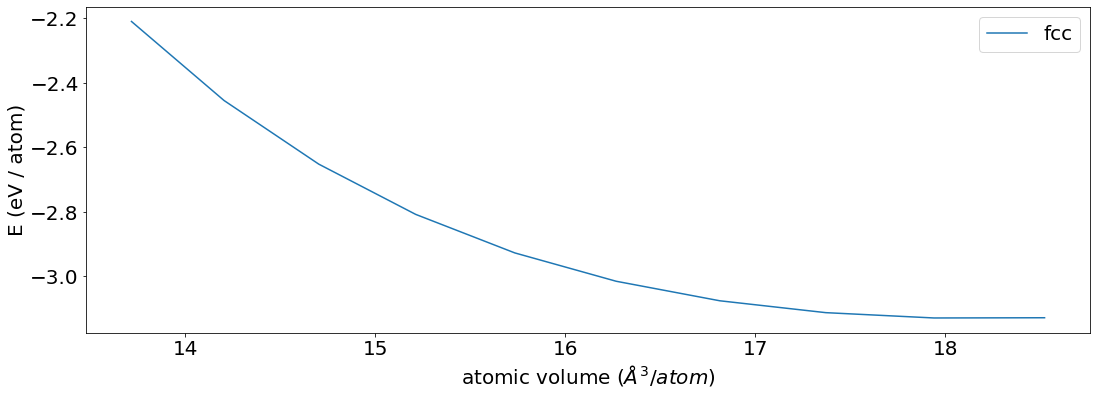

In [118]:
for (name, evcurve), case in zip(evcurves.items(), structures):
    structure = case[1]
    natoms = structure.get_global_number_of_atoms()
    plt.plot(np.array(evcurve['V'])/natoms,np.array(evcurve['E'])/natoms, label=name)
plt.legend()
xlabel=plt.xlabel('atomic volume ($\AA ^3 / atom $)')
ylabel = plt.ylabel('E (eV / atom)')
plt.savefig("E Vs. Volumen atomico.jpg")

## Ecuacion de estado

In [32]:
eos = EquationOfState(evcurves['fcc']['V'],evcurves['fcc']['E'],eos='birchmurnaghan')

In [33]:
eos.fit()

(72.76311152153961, -12.5265201753902, 0.8825198612824942)

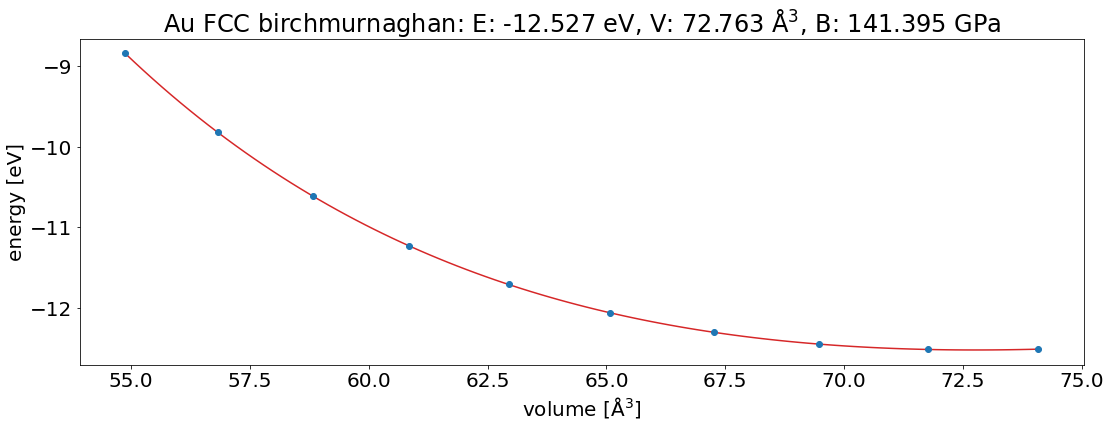

In [117]:
ax = eos.plot()
title = ax.get_title()
newtitle = ax.set_title('Au FCC ' + title)
plt.savefig("Au FCC birch....jpg")

In [35]:
eqa = eos.v0**(1/3)

In [121]:
eqa

4.174813579284903

Muy parecido a los resultados publicados en este trabajo de NOMAD: https://nomad-lab.eu/prod/v1/gui/search/entries/entry/id/YDXZgPooRb-31Niq48ODPA/SoO62gAV0cVK9WRCD5M-8Xh_T4OV

## Generación de superficie n capas

In [37]:
from ase.build import surface, fcc100, fcc110, fcc111, make_supercell

In [38]:
AuMonoLayer = fcc100('Au',[1,1,1], a=eqa, vacuum=10)

In [39]:
AuBiLayer = fcc100('Au',[1,1,2], a=eqa, vacuum=10)

In [40]:
AuTriLayer = fcc100('Au',[1,1,3], a=eqa, vacuum=10)

In [41]:
AuTetraLayer = fcc100('Au',[1,1,4], a=eqa, vacuum=10)

In [42]:
AuPentaLayer = fcc100('Au',[1,1,5], a=eqa, vacuum=10)

con lo cual construimos una n-capa de oro fcc con índices de miller 100. para poder visualizar esta bicapa con mas repeticiones, podemos repetir mas veces la supercelda que acabamos de crear,

In [43]:
AuMonoLayer_2x2 = make_supercell(AuMonoLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuMonoLayer_3x3 = make_supercell(AuMonoLayer, [[3,0,0],[0,3,0],[0,0,1]])

## MonoCAPA

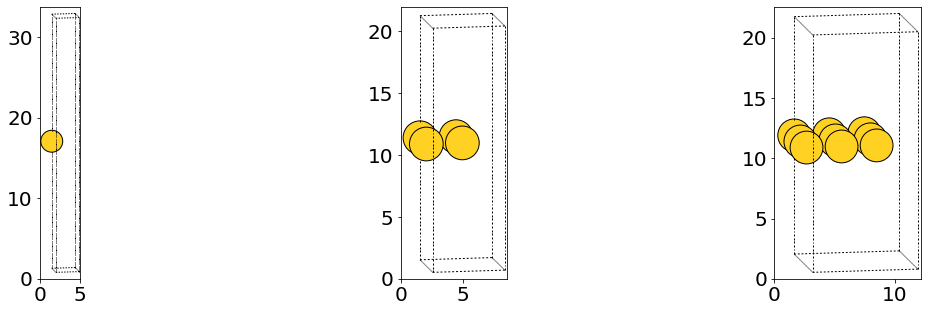

In [116]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_atoms(AuMonoLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuMonoLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuMonoLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])
plt.savefig("Mono.jpg")

# BiCapa

In [45]:
AuBiLayer_2x2 = make_supercell(AuBiLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuBiLayer_3x3 = make_supercell(AuBiLayer, [[3,0,0],[0,3,0],[0,0,1]])

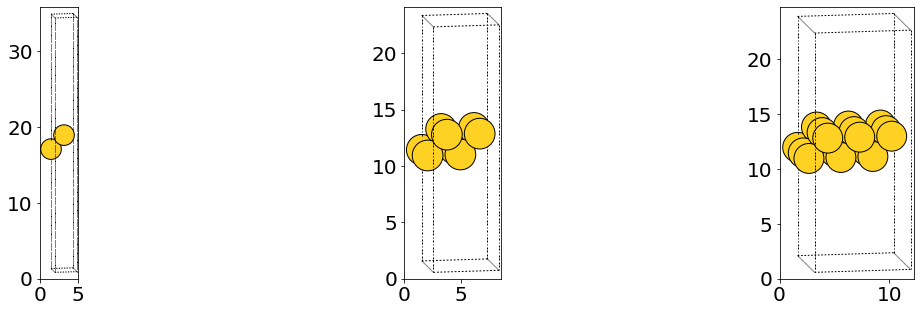

In [115]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_atoms(AuBiLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuBiLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuBiLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])
plt.savefig("Bi.jpg")

# TriCapa

In [47]:
AuTriLayer_2x2 = make_supercell(AuTriLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuTriLayer_3x3 = make_supercell(AuTriLayer, [[3,0,0],[0,3,0],[0,0,1]])

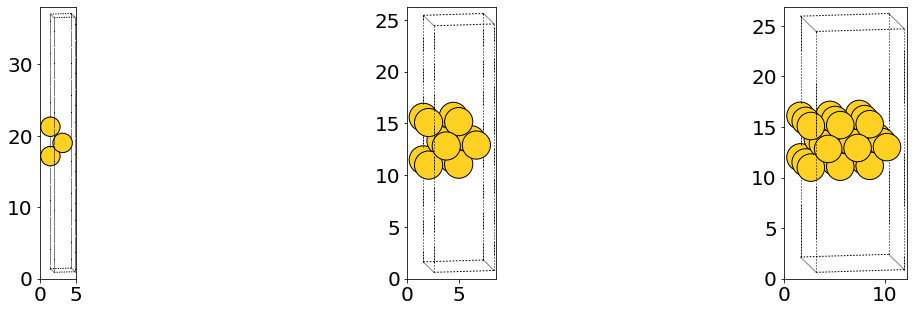

In [114]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_atoms(AuTriLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuTriLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuTriLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])
plt.savefig("Tri.jpg")

# TetraCapa

In [49]:
AuTetraLayer_2x2 = make_supercell(AuTetraLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuTetraLayer_3x3 = make_supercell(AuTetraLayer, [[3,0,0],[0,3,0],[0,0,1]])

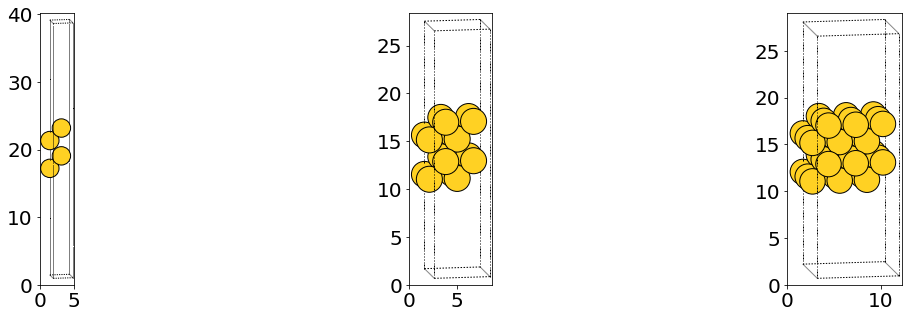

In [113]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_atoms(AuTetraLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuTetraLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuTetraLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])
plt.savefig("Tetra.jpg")

# Penta Capa

In [51]:
AuPentaLayer_2x2 = make_supercell(AuPentaLayer, [[2,0,0],[0,2,0],[0,0,1]])
AuPentaLayer_3x3 = make_supercell(AuPentaLayer, [[3,0,0],[0,3,0],[0,0,1]])

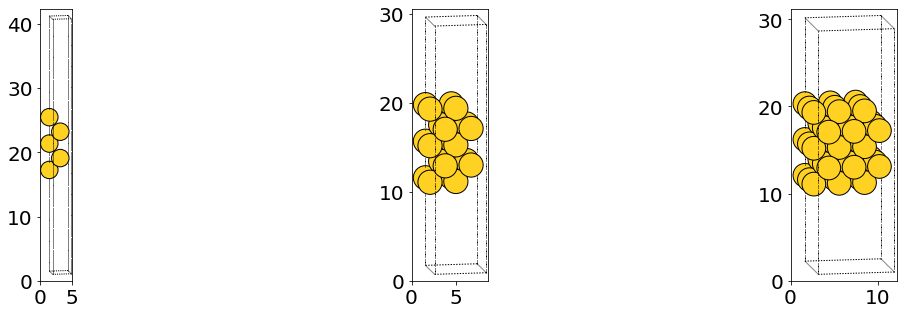

In [111]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plot_atoms(AuPentaLayer, rotation='90x, 10y, 10x', ax=ax[0])
plot_atoms(AuPentaLayer_2x2, rotation='90x, 10y, 10x', ax=ax[1])
plot_atoms(AuPentaLayer_3x3, rotation='90x, 10y, 10x', ax=ax[2])
plt.savefig("Penta.jpg")

## Calculos de superficies

In [53]:
layers_dir = 'layers_calcs'

In [54]:
if not os.path.exists(layers_dir):
    os.makedirs(layers_dir)

In [55]:
en_pot100= []

Monocapa de Au / 1° [100]

In [56]:
n = 1
monolayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
monolayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuMonolayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
calc = load_calc(monolayerfile, **GPAW_KWARGS)

AuMonoLayer.set_calculator(calc)
en_pot100.append((AuMonoLayer.get_potential_energy())/1)

In [57]:
AuMonoLayer.calc.write(monolayerfile)

Bicapa de Au / 1° [100]; 2° [110]

In [58]:
n = 2
bilayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
bilayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuBilayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
calcBiL = load_calc(bilayerfile, **GPAW_KWARGS)

AuBiLayer.set_calculator(calcBiL)
en_pot100.append((AuBiLayer.get_potential_energy())/2)

In [59]:
AuBiLayer.calc.write(bilayerfile)

Tricapa de Au / 1° [100]; 2° [110]

In [60]:
n = 3
trilayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
trilayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuTrilayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
calcTriL = load_calc(trilayerfile, **GPAW_KWARGS)

AuTriLayer.set_calculator(calcTriL)
en_pot100.append((AuTriLayer.get_potential_energy())/3)

In [61]:
AuTriLayer.calc.write(trilayerfile)

Tetracapa de Au / 1° [100]; 2° [110]

In [62]:
n = 4
tetralayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
tetralayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuTetralayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
calcTetraL = load_calc(tetralayerfile, **GPAW_KWARGS)

AuTetraLayer.set_calculator(calcTetraL)
en_pot100.append((AuTetraLayer.get_potential_energy())/4)

In [63]:
AuTetraLayer.calc.write(tetralayerfile)

Pentacapa de Au / 1° [100]

In [64]:
n = 5
pentalayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
pentalayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuPentalayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
calcPentaL = load_calc(pentalayerfile, **GPAW_KWARGS)

AuPentaLayer.set_calculator(calcPentaL)
en_pot100.append((AuPentaLayer.get_potential_energy())/5)

In [65]:
AuPentaLayer.calc.write(pentalayerfile)

No handles with labels found to put in legend.


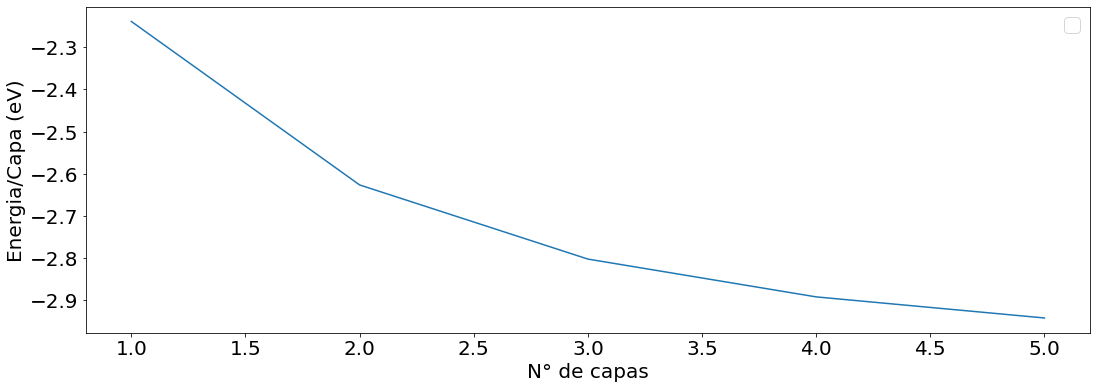

In [112]:
capas = np.array([1,2,3,4,5])
plt.plot(capas,en_pot100)
plt.xlabel('N° de capas')
plt.ylabel('Energia/Capa (eV)')
plt.legend()
#normalizado por la cantidad de atomos en las capas.
plt.savefig("Energia-Capa (eV) Vs. N de capas.jpg")

# Densidad de estados (DOS)

Bulk

In [67]:
AuFCC = bulk('Au', 'fcc', a=eqa)

In [68]:
bulk_dos_file = os.path.join(layers_dir, f'bulk_{n}_dos.gpaw')
bulk_dos_log = os.path.join(layers_dir, f'bulk_{n}_dos.txt')

In [69]:
GPAW_KWARGS_BULK=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,15], txt=bulk_dos_log)

In [70]:
calc = load_calc(bulk_dos_file, **GPAW_KWARGS_BULK)
AuFCC.set_calculator(calc)
AuFCC.get_potential_energy()

-3.1297045151325977

1 Capa

In [71]:
monolayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
monolayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [72]:
GPAW_KWARGS_monolayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt=monolayer_dos_log)

In [73]:
calcML = load_calc(monolayer_dos_file, **GPAW_KWARGS_monolayer)
AuMonoLayer.set_calculator(calcML)
AuMonoLayer.get_potential_energy()

-2.24065492568199

2 Capas

In [74]:
bilayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
bilayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [75]:
GPAW_KWARGS_bilayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt=bilayer_dos_log)

In [76]:
calcBiL = load_calc(bilayer_dos_file, **GPAW_KWARGS_bilayer)
AuBiLayer.set_calculator(calcBiL)
AuBiLayer.get_potential_energy()

-5.26241104468122

3 Capas

In [77]:
trilayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
trilayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [78]:
GPAW_KWARGS_trilayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt=trilayer_dos_log)

In [79]:
calcTriL = load_calc(trilayer_dos_file, **GPAW_KWARGS_trilayer)
AuTriLayer.set_calculator(calcTriL)
AuTriLayer.get_potential_energy()

-8.424773449716325

4 Capas

In [80]:
tetralayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
tetralayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [81]:
GPAW_KWARGS_tetralayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt=tetralayer_dos_log)

In [82]:
calcTetraL = load_calc(tetralayer_dos_file, **GPAW_KWARGS_tetralayer)
AuTetraLayer.set_calculator(calcTetraL)
AuTetraLayer.get_potential_energy()

-11.563907706898517

5 Capas

In [83]:
pentalayer_dos_file = os.path.join(layers_dir, f'layer_{n}_dos.gpaw')
pentalayer_dos_log = os.path.join(layers_dir, f'layer_{n}_dos.txt')

In [84]:
GPAW_KWARGS_pentalayer=dict(mode=PW(ECUT), xc='PBE', kpts=[15,15,1], txt=pentalayer_dos_log)

In [85]:
calcPentaL = load_calc(pentalayer_dos_file, **GPAW_KWARGS_pentalayer)
AuPentaLayer.set_calculator(calcPentaL)
AuPentaLayer.get_potential_energy()

-14.70961771908048

Calculo las energias y el DOS de las capas con los indices [100]

In [86]:
e,dos = AuFCC.calc.get_dos(npts=500)
e2_100, dos_ml_100 = AuMonoLayer.calc.get_dos(npts=500)
e3_100, dos_bl_100 = AuBiLayer.calc.get_dos(npts=500)
e4_100, dos_tril_100 = AuTriLayer.calc.get_dos(npts=500)
e5_100, dos_tetral_100 = AuTetraLayer.calc.get_dos(npts=500)
e6_100, dos_pental_100 = AuPentaLayer.calc.get_dos(npts=500)
ef = AuFCC.calc.get_fermi_level()
efml_100 = AuMonoLayer.calc.get_fermi_level()
efbl_100 = AuBiLayer.calc.get_fermi_level()
eftril_100 = AuTriLayer.calc.get_fermi_level()
eftetral_100 = AuTetraLayer.calc.get_fermi_level()
efpental_100 = AuPentaLayer.calc.get_fermi_level()

Gráfico para las capas con indices [100]

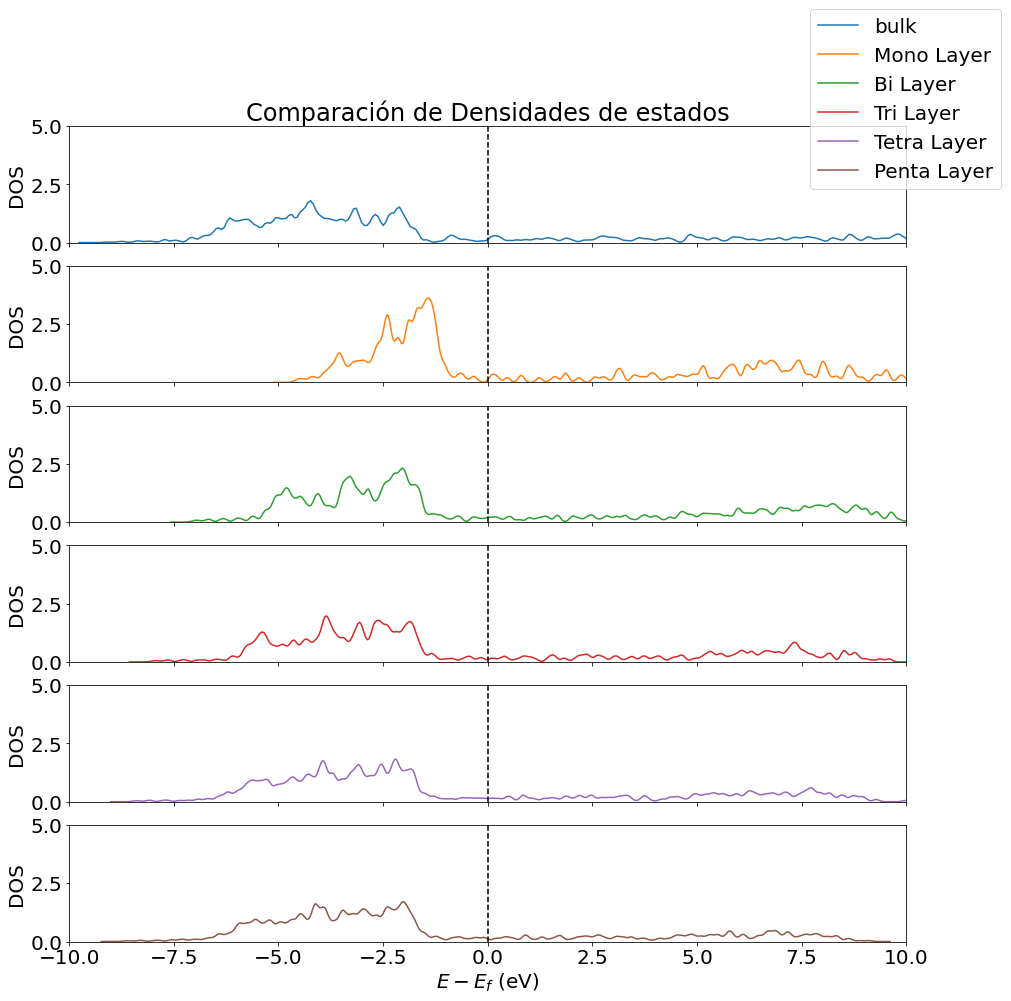

In [106]:
fig, ax = plt.subplots(6,1, figsize=(15,15), sharex=True)
ax[0].plot(e-ef,dos, label='bulk')
ax[1].plot(e2_100-efml_100,dos_ml_100, 'C1', label='Mono Layer')
ax[2].plot(e3_100-efbl_100,(dos_bl_100)/2, 'C2', label='Bi Layer')
ax[3].plot(e4_100-eftril_100,(dos_tril_100)/3, 'C3',label='Tri Layer')
ax[4].plot(e5_100-eftetral_100,(dos_tetral_100)/4,'C4' ,label='Tetra Layer')
ax[5].plot(e6_100-efpental_100,(dos_pental_100)/5,'C5' ,label='Penta Layer')
for i in range(6):
  ax[i].set_ylim((0, 5))
  ax[i].set_xlim((-10, 10))
  ax[i].set_ylabel('DOS')
  ax[i].axvline(color='k', linestyle='--')
ax[5].set_xlabel('$E - E_f$ (eV)')
ax[0].set_title('Comparación de Densidades de estados')
fig.legend()
plt.savefig("Comparación de Densidades de estados.jpg")

# Convergencia con el vacio

In [88]:
vacio = np.linspace(1,16,10)
en_pot ={}

In [89]:
for i in vacio:
  AuMonoLayer = fcc100('Au',[1,1,1], a=eqa, vacuum=i)
  AuBiLayer = fcc100('Au',[1,1,2], a=eqa, vacuum=i)
  AuTriLayer = fcc100('Au',[1,1,3], a=eqa, vacuum=i)
  AuTetraLayer = fcc100('Au',[1,1,4], a=eqa, vacuum=i)
  AuPentaLayer = fcc100('Au',[1,1,5], a=eqa, vacuum=i)
  layers_dir = 'layers_calcs'
  if not os.path.exists(layers_dir):
    os.makedirs(layers_dir)
  en_pot100= []
  n = 1
  monolayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  monolayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuMonolayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
  calc = load_calc(monolayerfile, **GPAW_KWARGS)

  AuMonoLayer.set_calculator(calc)
  en_pot100.append(AuMonoLayer.get_potential_energy())
  AuMonoLayer.calc.write(monolayerfile)

  n = 2
  bilayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  bilayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuBilayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
  calcBiL = load_calc(bilayerfile, **GPAW_KWARGS)

  AuBiLayer.set_calculator(calcBiL)
  en_pot100.append((AuBiLayer.get_potential_energy())/2)

  AuBiLayer.calc.write(bilayerfile)

  n = 3
  trilayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  trilayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuTrilayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
  calcTriL = load_calc(trilayerfile, **GPAW_KWARGS)

  AuTriLayer.set_calculator(calcTriL)
  en_pot100.append((AuTriLayer.get_potential_energy())/3)
  AuTriLayer.calc.write(trilayerfile)

  n = 4
  tetralayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  tetralayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuTetralayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
  calcTetraL = load_calc(tetralayerfile, **GPAW_KWARGS)

  AuTetraLayer.set_calculator(calcTetraL)
  en_pot100.append((AuTetraLayer.get_potential_energy())/4)
  AuTetraLayer.calc.write(tetralayerfile)

  n = 5
  pentalayerfile = os.path.join(layers_dir, f'layer_{n}.gpaw')
  pentalayerlog = os.path.join(layers_dir, f'layer_{n}.txt')
  GPAW_KWARGS = dict(mode=PW(ECUT), txt='AuPentalayer.txt', xc='PBE', kpts=[KPT, KPT, 1])
  calcPentaL = load_calc(pentalayerfile, **GPAW_KWARGS)

  AuPentaLayer.set_calculator(calcPentaL)
  en_pot100.append((AuPentaLayer.get_potential_energy())/5)
  AuPentaLayer.calc.write(pentalayerfile)

  en_pot[i]= en_pot100
  
  
#normalizado por la cantidad de atomos en las capas.

In [90]:
#en_100 es un vector donde tengo la energia de en_100[0:4] es la energia para las distintas capas a un mismo nivel de vacio.
en_pot[vacio[0]]

[1.991668060042653,
 -3.315762582528376,
 -0.9118916431611056,
 -3.134887568046713,
 -1.9830626232067239]

In [91]:
archivo= 'Energia para distintas capas y niveles de vacio.txt'
with open(archivo,'w') as f:
    f.write('Vacios\n ===============')
with open(archivo,'a') as f:
    f.write(f'\n Vacíos utilizados\n')
    f.write(f'{vacio}\n')
    f.write(f'\n Energia\n')
    f.write(f'{en_pot}\n')

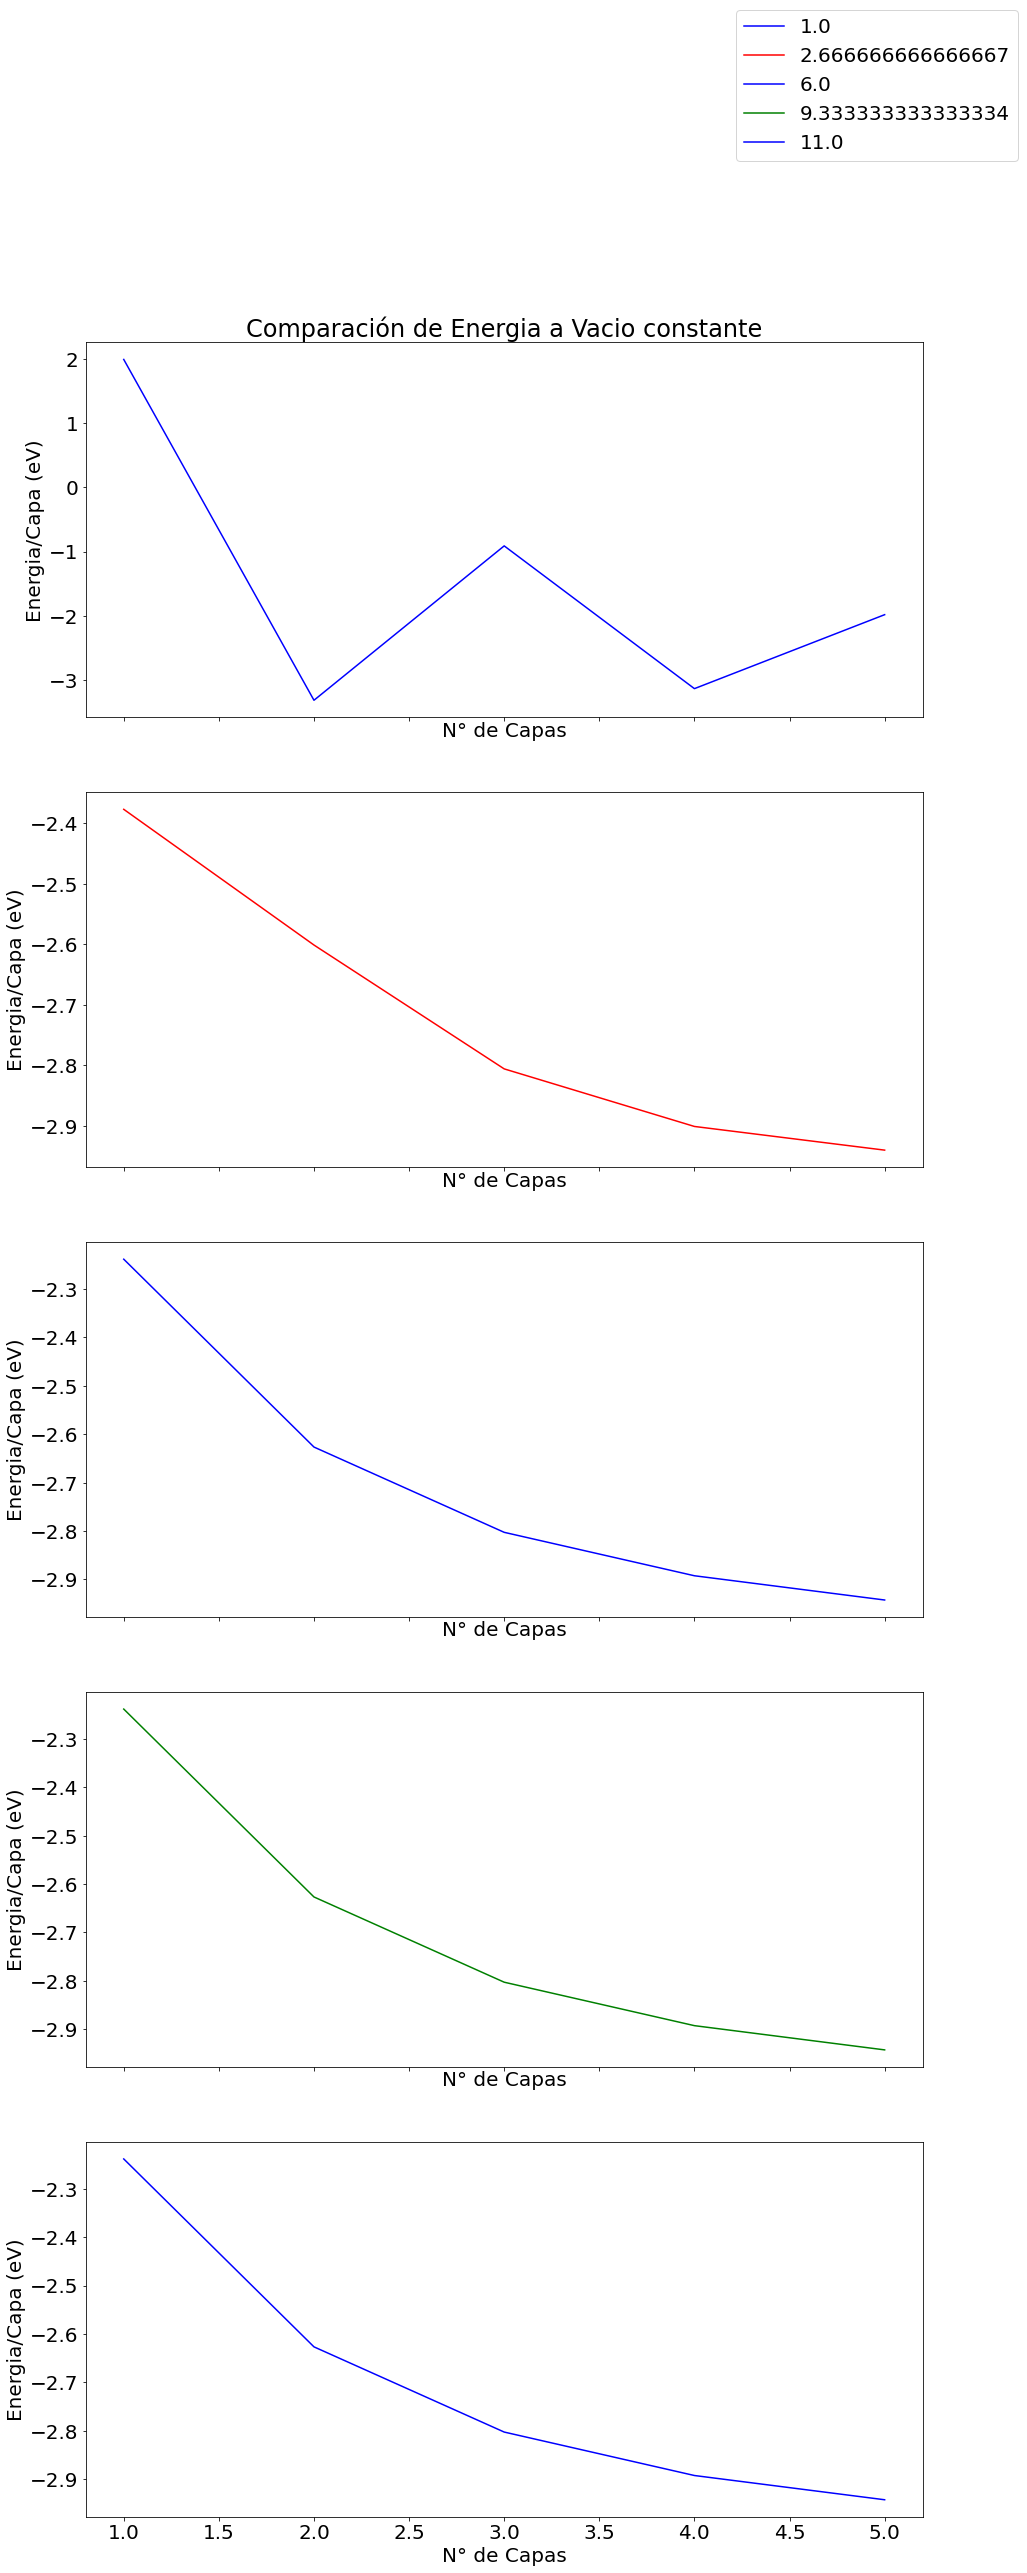

In [105]:
capas = np.array([1,2,3,4,5])
#plt.plot(e-ef,dos, label='bulk')
fig, ax = plt.subplots(5,1,figsize=(15,40), sharex=True)
ax[0].plot(capas,en_pot[vacio[0]],'b',label= vacio[0])
ax[1].plot(capas,en_pot[vacio[1]],'r',label= vacio[1])
#ax[2].plot(capas,en_pot[vacio[2]],'g',label= vacio[2])
ax[2].plot(capas,en_pot[vacio[3]],'b',label= vacio[3])
#ax[4].plot(capas,en_pot[vacio[4]],'r',label= vacio[4])
ax[3].plot(capas,en_pot[vacio[5]],'g',label= vacio[5])
ax[4].plot(capas,en_pot[vacio[6]],'b',label= vacio[6])
#ax[7].plot(capas,en_pot[vacio[7]],'r',label= vacio[7])
#ax[8].plot(capas,en_pot[vacio[8]],'g',label= vacio[8])
#ax[9].plot(capas,en_pot[vacio[9]],'b',label= vacio[9])
for i in range(0,5):
  ax[i].set_ylabel('Energia/Capa (eV)')
  ax[i].set_xlabel('N° de Capas')

ax[0].set_title('Comparación de Energia a Vacio constante')
fig.legend()
plt.savefig("Comparación de Energia a Vacio constante.jpg")

In [93]:
en_pot_1capa=[]
en_pot_2capa=[]
en_pot_3capa=[]
en_pot_4capa=[]
en_pot_5capa=[]

In [94]:
for n in range(0,5):
  for i in range(0,10):
    if n==0:
      en_pot_1capa.append(en_pot[vacio[i]][n])
    elif n==1:
      en_pot_2capa.append(en_pot[vacio[i]][n])
    elif n==2:
      en_pot_3capa.append(en_pot[vacio[i]][n])
    elif n==3:
      en_pot_4capa.append(en_pot[vacio[i]][n])
    elif n==4:
      en_pot_5capa.append(en_pot[vacio[i]][n])

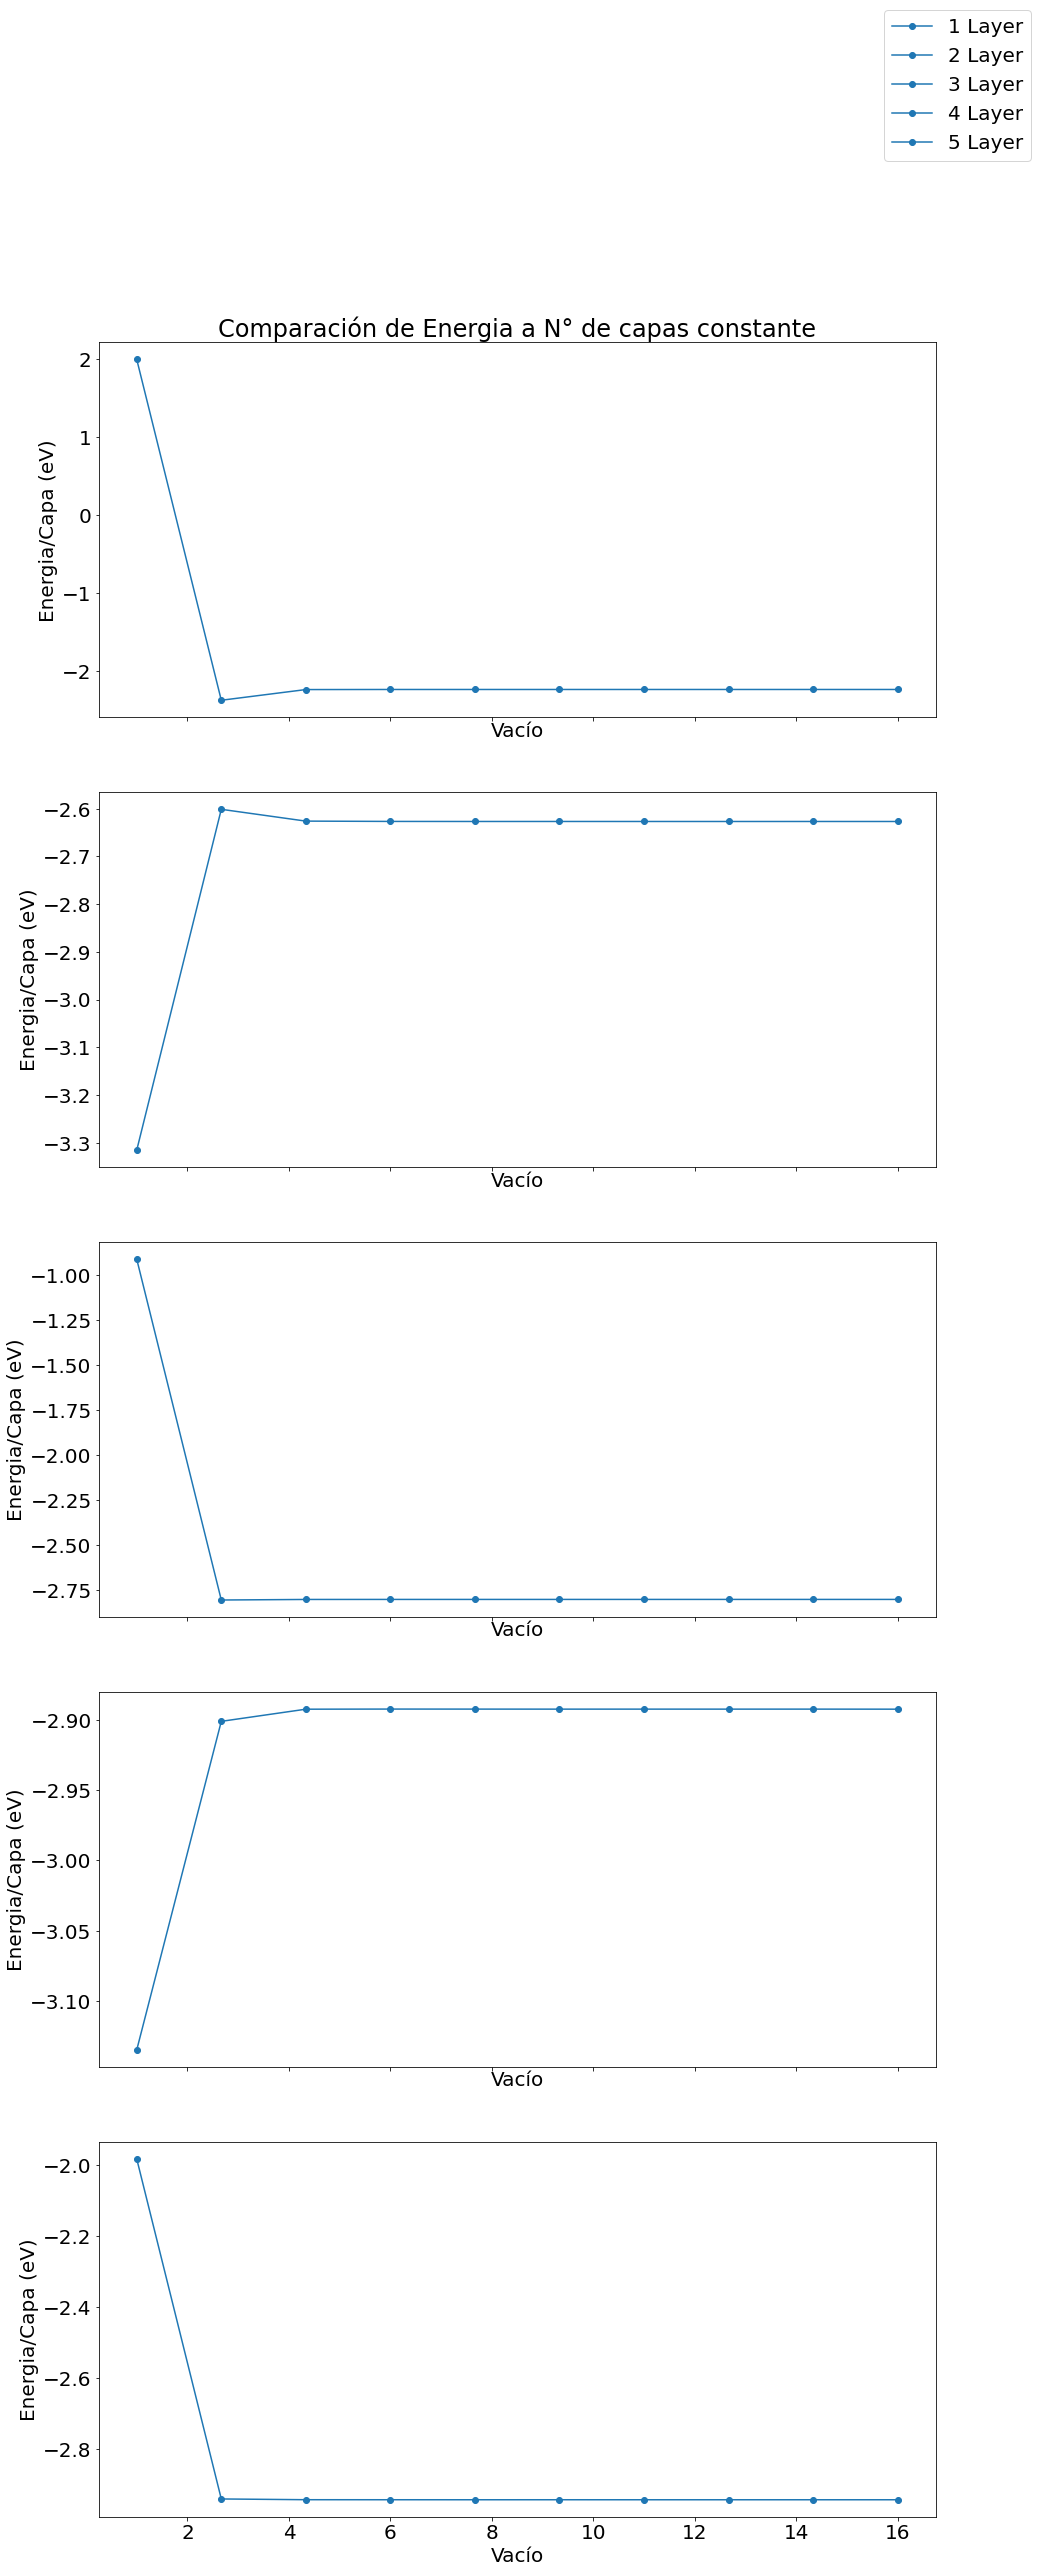

In [107]:
#plt.plot(e-ef,dos, label='bulk')
fig, ax = plt.subplots(5,1,figsize=(15,40), sharex=True)
ax[0].plot(vacio,en_pot_1capa,'-o',label= '1 Layer')
ax[1].plot(vacio,en_pot_2capa,'-o',label= '2 Layer')
ax[2].plot(vacio,en_pot_3capa,'-o',label= '3 Layer')
ax[3].plot(vacio,en_pot_4capa,'-o',label= '4 Layer')
ax[4].plot(vacio,en_pot_5capa,'-o',label= '5 Layer')

for i in range(0,5):
  ax[i].set_ylabel('Energia/Capa (eV)')
  ax[i].set_xlabel('Vacío')

ax[0].set_title('Comparación de Energia a N° de capas constante')
fig.legend()
plt.savefig("Comparación de Energia a N° de capas constante.jpg")